# Steel Defect Classification Using CIFAR-10 Examples (Multiclass)
This notebook demonstrates a simple approach to multiclass steel defect classification using the CIFAR-10 image dataset. We treat several CIFAR-10 classes as different steel defect types, build a neural network, and evaluate its performance using confusion matrices and appropriate metrics.

In [1]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

In [2]:
# Load CIFAR-10 Dataset using PyTorch
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load training and test datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Extract data for preprocessing
x_train = trainset.data  # numpy array (50000, 32, 32, 3)
y_train = np.array(trainset.targets)  # numpy array (50000,)
x_test = testset.data   # numpy array (10000, 32, 32, 3)
y_test = np.array(testset.targets)   # numpy array (10000,)

print('Train shape:', x_train.shape, y_train.shape)
print('Test shape:', x_test.shape, y_test.shape)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Train shape: (50000, 32, 32, 3) (50000,)
Test shape: (10000, 32, 32, 3) (10000,)
Train shape: (50000, 32, 32, 3) (50000,)
Test shape: (10000, 32, 32, 3) (10000,)


In [3]:
# Prepare Data for Multiclass Steel Defect Classification
# CIFAR-10 classes mapped to simulated steel defect types:
defect_mapping = {
    0: 'Surface Scratches',    # airplane
    1: 'Edge Cracks',          # automobile  
    2: 'Pitting Corrosion',    # bird
    3: 'Scale Formation',      # cat
    4: 'Decarburization',      # deer
    5: 'Inclusions',           # dog
    6: 'Roll Marks',           # frog
    7: 'Staining',             # horse
    8: 'Lamination',           # ship
    9: 'Good Steel'            # truck (no defects)
}

class_names = list(defect_mapping.values())
num_classes = 10  # Use all CIFAR-10 classes as different defect types

print("Steel Defect Types (Simulated):")
for i, defect_type in defect_mapping.items():
    print(f"  {i}: {defect_type}")

# Convert to PyTorch tensors and normalize
# PyTorch expects (N, C, H, W) format, CIFAR data is (N, H, W, C)
x_train_norm = torch.FloatTensor(x_train).permute(0, 3, 1, 2) / 255.0
x_test_norm = torch.FloatTensor(x_test).permute(0, 3, 1, 2) / 255.0
y_train_tensor = torch.LongTensor(y_train)
y_test_tensor = torch.LongTensor(y_test)

print(f'\nDataset shapes:')
print(f'Training - Images: {x_train_norm.shape}, Labels: {y_train_tensor.shape}')
print(f'Testing - Images: {x_test_norm.shape}, Labels: {y_test_tensor.shape}')

# Show class distribution
unique, counts = np.unique(y_train, return_counts=True)
print(f'\nTraining set class distribution:')
for i, count in zip(unique, counts):
    print(f'  {defect_mapping[i]}: {count} samples')

# Create data loaders for training
batch_size = 64
train_dataset = TensorDataset(x_train_norm, y_train_tensor)
test_dataset = TensorDataset(x_test_norm, y_test_tensor)

# Split training data for validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Steel Defect Types (Simulated):
  0: Surface Scratches
  1: Edge Cracks
  2: Pitting Corrosion
  3: Scale Formation
  4: Decarburization
  5: Inclusions
  6: Roll Marks
  7: Staining
  8: Lamination
  9: Good Steel

Dataset shapes:
Training - Images: torch.Size([50000, 3, 32, 32]), Labels: torch.Size([50000])
Testing - Images: torch.Size([10000, 3, 32, 32]), Labels: torch.Size([10000])

Training set class distribution:
  Surface Scratches: 5000 samples
  Edge Cracks: 5000 samples
  Pitting Corrosion: 5000 samples
  Scale Formation: 5000 samples
  Decarburization: 5000 samples
  Inclusions: 5000 samples
  Roll Marks: 5000 samples
  Staining: 5000 samples
  Lamination: 5000 samples
  Good Steel: 5000 samples

Dataset shapes:
Training - Images: torch.Size([50000, 3, 32, 32]), Labels: torch.Size([50000])
Testing - Images: torch.Size([10000, 3, 32, 32]), Labels: torch.Size([10000])

Training set class distribution:
  Surface Scratches: 5000 samples
  Edge Cracks: 5000 samples
  Pitting Corr

In [4]:
# Build a Simple Neural Network Model for Multiclass Classification using PyTorch
class SteelDefectCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SteelDefectCNN, self).__init__()
        # Convolutional layer to extract features from images
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the size after conv and pooling: (32-3+2*1)/1 + 1 = 32, then pool: 32/2 = 16
        # So after conv1 and pool: 16x16x16
        self.fc1 = nn.Linear(16 * 16 * 16, 32)
        self.fc2 = nn.Linear(32, num_classes)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        # Convolutional and pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        
        # Flatten for dense layers
        x = x.view(-1, 16 * 16 * 16)
        
        # Dense layers for classification
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)  # No softmax here, will use CrossEntropyLoss
        
        return x

# Create model instance
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = SteelDefectCNN(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Combines softmax and negative log likelihood
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model Architecture for Steel Defect Classification:")
print(model)

print(f"\nModel Output: {num_classes} classes representing different defect types")
print("Loss Function: CrossEntropyLoss (includes softmax internally)")

# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Using device: cpu
Model Architecture for Steel Defect Classification:
SteelDefectCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4096, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

Model Output: 10 classes representing different defect types
Loss Function: CrossEntropyLoss (includes softmax internally)
Total trainable parameters: 131882


In [5]:
# Train the Model
print("Training multiclass steel defect classification model...")
print(f"Training on {len(train_dataset)} samples with {num_classes} defect classes")

num_epochs = 5
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += target.size(0)
        correct_train += (predicted == target).sum().item()
        
        # Print progress every 100 batches
        if batch_idx % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_loader)}, '
                  f'Loss: {loss.item():.4f}')
    
    # Calculate training metrics
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            val_loss += criterion(outputs, target).item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
    
    # Calculate validation metrics
    val_loss /= len(val_loader)
    val_acc = 100. * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    print('-' * 50)

# Store history for plotting (similar to Keras history object)
class History:
    def __init__(self):
        self.history = {
            'loss': train_losses,
            'accuracy': [acc/100 for acc in train_accuracies],  # Convert to 0-1 scale
            'val_loss': val_losses,
            'val_accuracy': [acc/100 for acc in val_accuracies]  # Convert to 0-1 scale
        }

history = History()
print("\nTraining completed!")

Training multiclass steel defect classification model...
Training on 40000 samples with 10 defect classes
Epoch 1/5, Batch 0/625, Loss: 2.3233
Epoch 1/5, Batch 100/625, Loss: 2.2211
Epoch 1/5, Batch 100/625, Loss: 2.2211
Epoch 1/5, Batch 200/625, Loss: 1.9761
Epoch 1/5, Batch 200/625, Loss: 1.9761
Epoch 1/5, Batch 300/625, Loss: 2.0550
Epoch 1/5, Batch 300/625, Loss: 2.0550
Epoch 1/5, Batch 400/625, Loss: 2.0812
Epoch 1/5, Batch 400/625, Loss: 2.0812
Epoch 1/5, Batch 500/625, Loss: 2.0114
Epoch 1/5, Batch 500/625, Loss: 2.0114
Epoch 1/5, Batch 600/625, Loss: 1.8760
Epoch 1/5, Batch 600/625, Loss: 1.8760
Epoch 1/5:
  Train Loss: 2.0561, Train Acc: 21.01%
  Val Loss: 1.8052, Val Acc: 37.00%
--------------------------------------------------
Epoch 2/5, Batch 0/625, Loss: 1.8868
Epoch 1/5:
  Train Loss: 2.0561, Train Acc: 21.01%
  Val Loss: 1.8052, Val Acc: 37.00%
--------------------------------------------------
Epoch 2/5, Batch 0/625, Loss: 1.8868
Epoch 2/5, Batch 100/625, Loss: 1.9394


In [6]:
# Evaluate Model Performance
print("Evaluating model on test set...")

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        test_loss += criterion(outputs, target).item()
        
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

test_loss /= len(test_loader)
test_acc = correct / total

print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Loss: {test_loss:.4f}')

Evaluating model on test set...
Test Accuracy: 0.4867
Test Loss: 1.5365
Test Accuracy: 0.4867
Test Loss: 1.5365


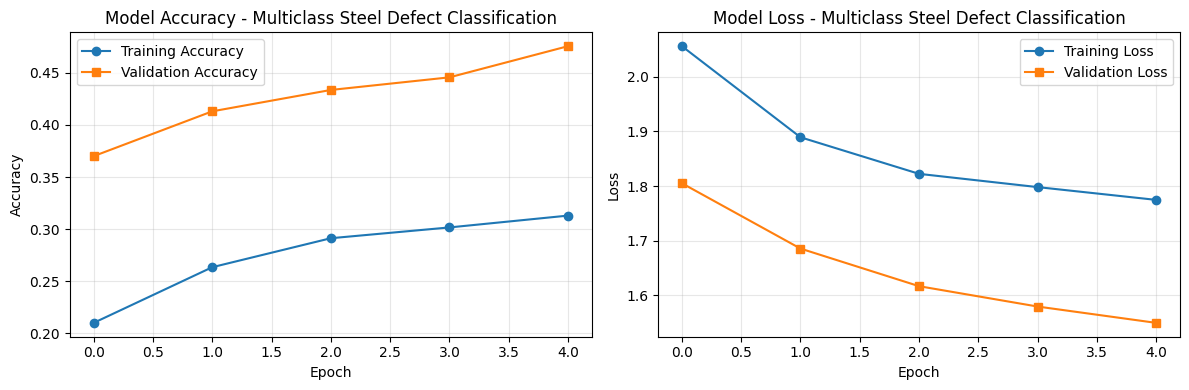

In [7]:
# Visualize Training History
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Model Accuracy - Multiclass Steel Defect Classification')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Model Loss - Multiclass Steel Defect Classification')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Model Evaluation and Analysis
Now let's thoroughly evaluate our trained multiclass model using various metrics and visualizations to understand its performance on the steel defect classification task with multiple defect types.

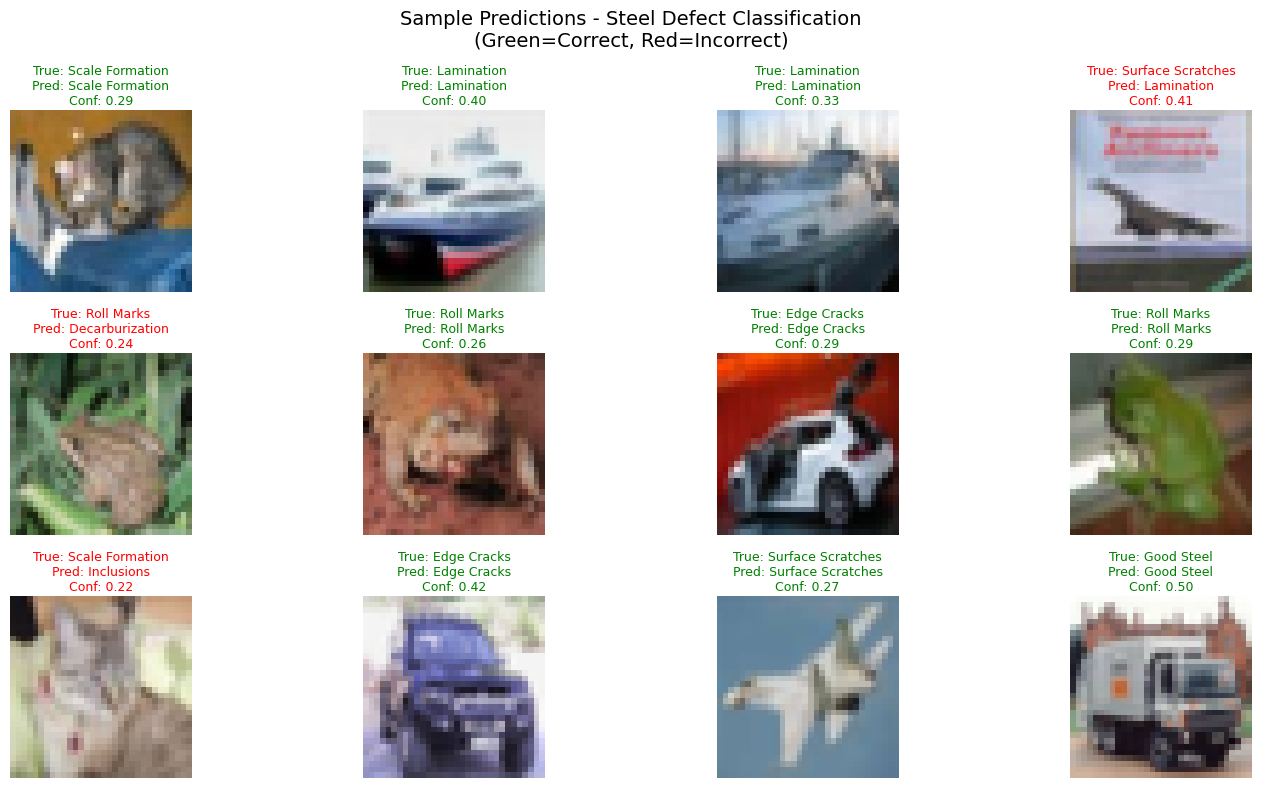

Sample accuracy: 0.75 (9/12 correct)


In [8]:
# Predict Defects on Sample Images
model.eval()

# Get sample images and labels
sample_images = x_test_norm[:12].to(device)  # Show 12 samples for better grid
sample_labels = y_test[:12]

with torch.no_grad():
    sample_outputs = model(sample_images)
    sample_preds_proba = F.softmax(sample_outputs, dim=1)
    sample_preds = torch.argmax(sample_outputs, dim=1)

# Convert back to numpy for plotting
sample_images_np = sample_images.cpu().permute(0, 2, 3, 1).numpy()
sample_preds_proba_np = sample_preds_proba.cpu().numpy()
sample_preds_np = sample_preds.cpu().numpy()

# Denormalize images for display (from [0,1] to [0,1])
sample_images_display = np.clip(sample_images_np, 0, 1)

plt.figure(figsize=(15, 8))
for i in range(12):
    plt.subplot(3, 4, i+1)
    plt.imshow(sample_images_display[i])
    plt.axis('off')
    
    # Get actual and predicted defect types
    actual_defect = class_names[sample_labels[i]]
    predicted_defect = class_names[sample_preds_np[i]]
    confidence = sample_preds_proba_np[i][sample_preds_np[i]]
    
    # Color code: green for correct, red for incorrect
    color = 'green' if sample_labels[i] == sample_preds_np[i] else 'red'
    
    plt.title(f'True: {actual_defect}\nPred: {predicted_defect}\nConf: {confidence:.2f}', 
              fontsize=9, color=color, wrap=True)

plt.suptitle('Sample Predictions - Steel Defect Classification\n(Green=Correct, Red=Incorrect)', 
             fontsize=14, y=0.98)
plt.tight_layout()
plt.show()

# Calculate and display sample accuracy
sample_accuracy = np.mean(sample_labels == sample_preds_np)
print(f"Sample accuracy: {sample_accuracy:.2f} ({np.sum(sample_labels == sample_preds_np)}/{len(sample_labels)} correct)")

=== Multiclass Steel Defect Classification Results ===



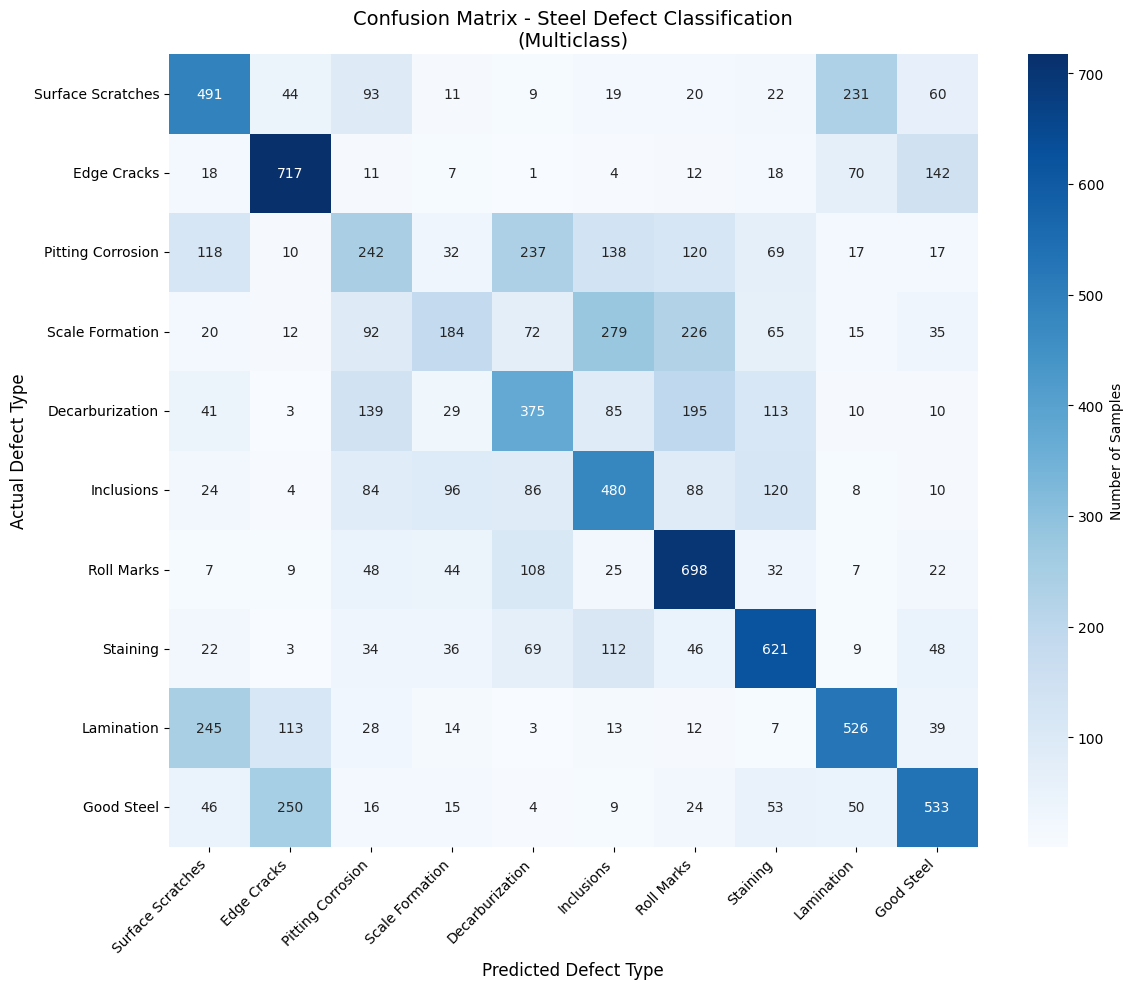

Overall Test Accuracy: 0.4867

Detailed Classification Report:
                   precision    recall  f1-score   support

Surface Scratches     0.4758    0.4910    0.4833      1000
      Edge Cracks     0.6155    0.7170    0.6624      1000
Pitting Corrosion     0.3075    0.2420    0.2708      1000
  Scale Formation     0.3932    0.1840    0.2507      1000
  Decarburization     0.3890    0.3750    0.3819      1000
       Inclusions     0.4124    0.4800    0.4436      1000
       Roll Marks     0.4844    0.6980    0.5719      1000
         Staining     0.5545    0.6210    0.5858      1000
       Lamination     0.5578    0.5260    0.5414      1000
       Good Steel     0.5819    0.5330    0.5564      1000

         accuracy                         0.4867     10000
        macro avg     0.4772    0.4867    0.4748     10000
     weighted avg     0.4772    0.4867    0.4748     10000


Per-Class Accuracy Analysis:
Surface Scratches   : 0.4910 (491/1000)
Edge Cracks         : 0.7170 (717/1000

In [9]:
# Generate predictions for comprehensive evaluation
model.eval()

y_pred_list = []
y_pred_proba_list = []
y_true_list = []

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        proba = F.softmax(outputs, dim=1)
        
        y_pred_list.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        y_pred_proba_list.extend(proba.cpu().numpy())
        y_true_list.extend(target.cpu().numpy())

y_pred = np.array(y_pred_list)
y_pred_proba = np.array(y_pred_proba_list)
y_true = np.array(y_true_list)

# Confusion Matrix and Classification Metrics
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

print("=== Multiclass Steel Defect Classification Results ===\n")

# Enhanced Confusion Matrix Visualization
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_true, y_pred)

# Create heatmap with defect type labels
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Number of Samples'})
plt.xlabel('Predicted Defect Type', fontsize=12)
plt.ylabel('Actual Defect Type', fontsize=12)
plt.title('Confusion Matrix - Steel Defect Classification\n(Multiclass)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Overall Accuracy
overall_accuracy = accuracy_score(y_true, y_pred)
print(f'Overall Test Accuracy: {overall_accuracy:.4f}\n')

# Detailed Classification Report
print('Detailed Classification Report:')
print('='*50)
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

# Per-class accuracy analysis
print('\nPer-Class Accuracy Analysis:')
print('='*40)
for i, defect_type in enumerate(class_names):
    class_mask = y_true == i
    if np.sum(class_mask) > 0:
        class_accuracy = np.mean(y_pred[class_mask] == y_true[class_mask])
        total_samples = np.sum(class_mask)
        correct_samples = np.sum(y_pred[class_mask] == y_true[class_mask])
        print(f'{defect_type:20s}: {class_accuracy:.4f} ({correct_samples:3d}/{total_samples:3d})')
    else:
        print(f'{defect_type:20s}: No samples in test set')

## Summary and Next Steps

### What We Accomplished
This notebook demonstrated a complete **multiclass classification pipeline** for steel defect detection using:
- **Data Mapping**: Mapped CIFAR-10 classes to simulated steel defect types (10 categories)
- **Model Architecture**: Built a CNN with softmax output for multiclass classification
- **Training**: Monitored training/validation performance across multiple epochs
- **Comprehensive Evaluation**: Analyzed performance using confusion matrix, classification report, and per-class metrics

### Key Insights from Multiclass Analysis
- **Class Performance Variation**: Some defect types may be easier to classify than others
- **Confusion Patterns**: The confusion matrix reveals which defect types are commonly misclassified
- **Balanced vs Imbalanced**: Real steel defect datasets often have class imbalance (some defects are rarer)
- **Multiclass Complexity**: More classes mean more potential confusion between similar defect types

### Comparison with Binary Classification
- **Binary**: Simple defective vs non-defective (higher accuracy, simpler decision boundary)
- **Multiclass**: Distinguishes between different defect types (more complex, lower accuracy per class)
- **Use Cases**: Binary for pass/fail inspection, multiclass for defect type identification and repair planning

### For Real-World Multiclass Steel Defect Classification

#### 1. **Dataset Improvements**
- Use actual steel surface images with real defect annotations
- Address class imbalance with stratified sampling or synthetic data generation
- Ensure consistent image quality and lighting conditions

#### 2. **Advanced Model Architectures**
- **Transfer Learning**: Use pre-trained models (ResNet, EfficientNet, Vision Transformers)
- **Attention Mechanisms**: Focus on defect regions automatically
- **Ensemble Methods**: Combine multiple models for better robustness

#### 3. **Data Augmentation Strategies**
- Rotation, scaling, brightness/contrast adjustments
- Defect-specific augmentations (simulate different lighting, angles)
- Synthetic defect generation using GANs

#### 4. **Performance Optimization**
- **Class Weighting**: Handle imbalanced datasets
- **Focal Loss**: Focus training on hard-to-classify samples
- **Multi-scale Training**: Train on different image resolutions

#### 5. **Industrial Implementation**
- **Real-time Processing**: Optimize for speed in production lines
- **Confidence Thresholding**: Reject ambiguous classifications for human review
- **Integration**: Connect with existing quality control systems
- **Continuous Learning**: Update model with new defect types and patterns

### Critical Considerations for Steel Industry
- **Safety**: Missing critical defects could lead to structural failures
- **Cost**: False positives waste material, false negatives risk product quality
- **Traceability**: Maintain records of defect classifications for quality audits
- **Standards Compliance**: Meet industry standards (ASTM, ISO) for defect classification